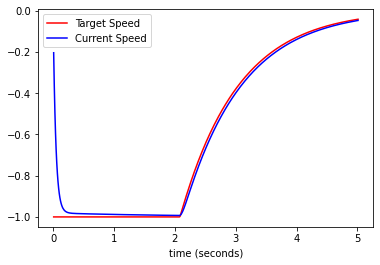

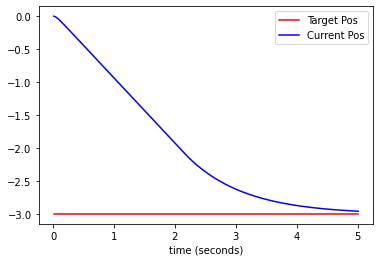

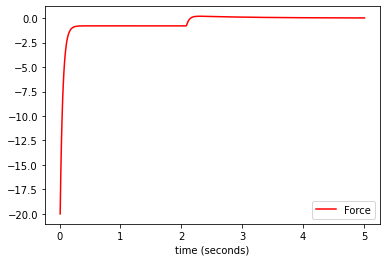

In [5]:
import sys
sys.path.append("../../")

from lib.data.dataplot import *
from lib.system.basic import *
from lib.system.controllers import *
from lib.system.cart import *
from lib.utils.time import *

    
class SpeedSmoother:
    
    def __init__(self, acc, max_speed):
        self.acceleration = acc
        self.v_max = max_speed
        self.v = 0
        
    def evaluate(self, delta_t, speed):
        current_acc = (speed - self.v) / delta_t
        if current_acc > self.acceleration:
            self.v = self.v + self.acceleration * delta_t
            if self.v > self.max_speed:
                self.v = self.max_speed
        else:
            self.v = speed
        return self.v
        

class PositionSpeedControl:
    
    def __init__(self, kp_pos, sat_pos, kp_speed, ki_speed, sat_speed, accel):
        self.position_controller = P_Controller(kp_pos, sat_pos)
        self.speed_controller = PI_Controller(kp_speed, ki_speed, sat_speed)
        self.smoother = SpeedSmoother(accel,sat_speed)
        self.target_pos = 0
        self.target_speed = 0
        
    def set_target_position(self, p):
        self.target_pos = p
        
    def evaluate(self, delta_t, current_pos, current_speed):
        pos_error = self.target_pos - current_pos
        self.target_speed = self.position_controller.evaluate(delta_t, pos_error)
        self.target_speed = self.smoother.evaluate(delta_t, self.target_speed)
        
        speed_error = self.target_speed - current_speed
        out = self.speed_controller.evaluate(delta_t, speed_error)
        return out
    

pos_dp = DataPlotter()
pos_dp.set_x("time (seconds)")
pos_dp.add_y("target", "Target Pos")
pos_dp.add_y("current", "Current Pos")

spd_dp = DataPlotter()
spd_dp.set_x("time (seconds)")
spd_dp.add_y("target", "Target Speed")
spd_dp.add_y("current", "Current Speed")

f_dp = DataPlotter()
f_dp.set_x("time (seconds)")
f_dp.add_y("force", "Force")

cart = Cart(1.0, 0.8)

ctrl = PositionSpeedControl(1.0, 1.0,     # kp = 2, sat = 1 m/s
                            20.0, 10.0, 20.0, # kp =20, ki = 10, sat = 20 N
                            2.0) # acc = 2 m/s^2 


t = Time()
t.start()

current_speed = cart.speed
current_pos = cart.position

ctrl.set_target_position(3)

while t.get() < 5:
    
    time.sleep(0.01)
    delta_t = t.elapsed()
    
    force = ctrl.evaluate(delta_t, current_pos, current_speed)
    (current_pos, current_speed) = cart.evaluate(delta_t, force)
    
    spd_dp.append_x(t.get())
    spd_dp.append_y("target", ctrl.target_speed)
    spd_dp.append_y("current", current_speed)
    
    pos_dp.append_x(t.get())
    pos_dp.append_y("target", ctrl.target_pos)
    pos_dp.append_y("current", current_pos)
    
    f_dp.append_x(t.get())
    f_dp.append_y("force", force)
    
spd_dp.plot()
pos_dp.plot()
f_dp.plot()
